In [223]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from Pairwise import * 

In [186]:
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
# If you're setting the API key directly in your script, uncomment the next line 

def room_setup(scene_descriptor, api_key=api_key):
    url = 'https://api.openai.com/v1/chat/completions'
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json',
            }
    
    # Read the contents of the .py file
    file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
    with open(file_path, 'r') as file:
        file_contents = file.read()

    prompt1 = "I am designing the layout for" + scene_descriptor + ". Please give me the dimensions of the room,"
    prompt1 += " as well as the number of windows, doors, and sockets. For each window, door, and socket tell me the dimensions (in meters),"
    prompt1 += " which wall it should be on, as well as where on the wall it should be (this is a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: "
    prompt1 += "{Room: width = 5,  length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}, etc." 
    prompt1 += "The windows and doors should all have length 0.1. Ensure that every object has dimensions, position, and wall. "
    prompt1 += "No other text please. Just the list with no commentary or explanation."
    response1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt1}],
        max_tokens=500
    )
    objects = response1.choices[0].message.content.split("}, {")

    prompt2 = f"I am going to give you a set of functions that are used to create a room and put objects in it. The functions are as follows:"
    prompt2 += "\n\n{file_contents}\n\n"
    prompt2 += f"I now want, for each element in this list: {objects}, with room descriptor:" + scene_descriptor + ", for you to translate it into a function call using the functions I gave you above."
    prompt2 += " For example, given the room descriptor 'a small kitchen' as well as the list: "
    prompt2 += "{Room: width = 5,  length = 6}, {Object type: window, Number: 1,  width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:"
    prompt2 += "kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3)."#, kitchen.draw()."
    prompt2 += " Return only the python script. No other text. Please ensure the correct number of inputs are given for each function."
    prompt2 += file_contents

    # Define the request payload
    data = {
        "model": "gpt-4",
        "messages": [
            {"role": "user", "content": prompt2}
        ]
    }
    
    # Make the API call
    response2 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response2.status_code == 200:
        response_data2 = response2.json()
        if "```python" in response_data2['choices'][0]['message']['content']:
            response2 = (response_data2['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        elif "```" in response_data2['choices'][0]['message']['content']:
            response2 = (response_data2['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
        else: 
            response2 = response_data2['choices'][0]['message']['content']
        print(response2)
        exec(response2)
    else:
        print('Failed to get a response')
        print(response2.text)

    return response1, response2

scene_descriptor = "a large bedroom for a young couple"
response1, response2 = room_setup(scene_descriptor)

width = (response2.split("create_room("))[1].split(",")[0]
length = (response2.split("create_room("))[1].split(",")[1].split(")")[0]

large_bedroom = create_room(6, 8)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'north', position = 0.1)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'west', position = 0.5)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'south', position = 0.3)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'south', position = 0.7)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'east', position = 0.5)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'north', position = 0.9)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'east', position = 0.25)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'west', position = 0.75)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'south', position = 0.2)


In [187]:
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
        }

# Read the contents of the .py file
file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
with open(file_path, 'r') as file:
    file_contents = file.read()

prompt3 = "Interior designers suggest that rooms should have distinct regions in them for different functions. Given the description:"
prompt3 += scene_descriptor
prompt3 += " Bear in mind the size of the room: width = " + width + ", length = " + length
prompt3 += ", what regions should this room have? Pick a reasonable number of these for this room (ensure that the most important are included)"
prompt3 += " and return them in a simple list. For example if the scene description was 'An open plan kitchen dining room', the output would be "
prompt3 += "'cooking region, dining region, cleaning region' etc. Please give no other text."

response3 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt3}],
        max_tokens=500
    )

prompt4 = "Given the room so far: " + response2 + ", and the regions: " + response3.choices[0].message.content
prompt4 += " Using the functions in the script, initialise each region. For example 'eating region' might output 'eating_region = region_setup(kitchen, 'eating', 0)."
prompt4 += " No other text please, only the python script. Don't include the room so far in the output."
prompt4 += file_contents
 # Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt4}
            ]
    }
    
# Make the API call
response4 = requests.post(url, headers=headers, json=data)  
# Check the response
if response4.status_code == 200:
    response_data4 = response4.json()
    if "```python" in response_data4['choices'][0]['message']['content']:
        response4 = response2 + "\n" + (response_data4['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    else: 
        response4 = response2 + "\n" + response_data4['choices'][0]['message']['content']
        print(response4)
        global_context = globals().copy()
        local_context = {}  
        exec(response4, global_context, local_context)
else:
    print('Failed to get a response')
    print(response4.text)

large_bedroom = create_room(6, 8)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'north', position = 0.1)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'west', position = 0.5)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'south', position = 0.3)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'south', position = 0.7)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'east', position = 0.5)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'north', position = 0.9)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'east', position = 0.25)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'west', position = 0.75)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'south', position = 0.2)
sleeping_region = region_setup(large_bedroom, 'sleeping', 0)
dressing_region = region_setup(large_bedroom, 'dressing', 1)
seating_region = region_setup(large_bedroom, 'seating', 2)
workspace_region = region_setup(large_bedroom, 'workspace', 3)


In [188]:
room_name = ((response4).split(" =")[0]).split("\n")[-1]

fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

room_width = local_context[room_name].width
room_length = local_context[room_name].length

region_names = ""
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
    else: 
        region_names += local_context[room_name].regions[i].name + "."
print(region_names)

sleeping, dressing, seating, workspace.


In [189]:
prompt5 = "I am going to give you a description of a room, as well as all the fixed objects inside it (e.g. windows) and the dimensions of the room."
prompt5 += " I am also going to give you the different regions for the room. Based on this information, "
prompt5 += "I want returned the most important or biggest object for each region"
prompt5 += " and the dimensions for those objects in meters. This should include width (this is the width of the back of the object) and length (length of the side of the object), not height. The room description is: "
prompt5 += scene_descriptor + ", and the regions are: " + region_names + ". The fixed objects are: " + fixed_objects
prompt5 += " Finally, the room dimensions are, width : " + str(room_width) + " meters, and length : " + str(room_length) + " meters."
prompt5 += "Please return it in the format of {object_name: name, object_width: width, object_length: length, region: region_name}. After the list, I also want you to give me all the constraints for each object"
prompt5 += " that depend on the items in the room (e.g. walls, windows, doors, sockets), they cannot depend on any other items in this list. For example if an object should have its back against a wall (e.g. bed or wardrobe), or if it should be far away from a window, or near a socket."
prompt5 += "Please be as detailed as possible, for example giving which side should be against the wall or how far away from the window. "
prompt5 += "I also want for each object an accessibility constraint about its usage (to prevent the sides being blocked), something like 'the bed should be accessible from the left, right, and front' or 'the sofa should be accessible from the front'. Give all of these as simply as possible, in the following format:  "
prompt5 += "{object_name: name, constraints: [constraint1, constraint2, ...]}. Give no other text in the response. Remove any constraints that involve other objects in the list."

response5 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt5}],
        max_tokens=1000
    )

print(response5.choices[0].message.content)
num_primary_objects = len(region_names.split(","))

[{object_name: bed, object_width: 2, object_length: 2.1, region: sleeping},
{object_name: wardrobe, object_width: 1.5, object_length: 0.6, region: dressing},
{object_name: sofa, object_width: 1.8, object_length: 0.9, region: seating},
{object_name: desk, object_width: 1.4, object_length: 0.7, region: workspace}]

[{object_name: bed, constraints: [back against a wall, at least 1 meter away from windows, accessible from the left, right, and front]},
{object_name: wardrobe, constraints: [back against a wall, accessible from the front]},
{object_name: sofa, constraints: [back against a wall, accessible from the front]},
{object_name: desk, constraints: [back against a wall, near a socket, accessible from the front]}]


In [190]:
prompt6 = "I am going to give you a description of a room, as well as some objects within it."
prompt6 += "I want returned any constraints between the objects in the room (not the windows, doors, sockets, or walls, but the items like beds, sofas, etc)."
prompt6 += "The room description is: " + scene_descriptor
prompt6 += ", and the objects are: " + response5.choices[0].message.content.split("]")[0][1:]
prompt6 += "Please return it in the format of a list of constraints like this: {object_name_1: name, object_name_2: name, constraints: [constraint1, ..]}."
prompt6 += "An example of a constraint would be {object_name_1: 'bed', object_name_2: 'desk', constraint: objects should not be near each other} (and you can specify how far they should be if you want). Remember to ONLY INCLUDE items on the list."
prompt6 += "Give no other text in the response. 'Region = different' is not a constraint that I am interested in."
response6 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt6}],
        max_tokens=1000
    )

response6 = response6.choices[0].message.content
print(response6)

[
    {object_name_1: 'bed', object_name_2: 'wardrobe', constraints: ['objects should have enough space for access to wardrobe']},
    {object_name_1: 'bed', object_name_2: 'sofa', constraints: ['objects should not obstruct each other', 'objects should not be near each other']},
    {object_name_1: 'bed', object_name_2: 'desk', constraints: ['objects should not be near each other', 'objects should allow enough space for movement']},
    {object_name_1: 'wardrobe', object_name_2: 'sofa', constraints: ['objects should have enough space for access to wardrobe']},
    {object_name_1: 'wardrobe', object_name_2: 'desk', constraints: ['objects should not obstruct each other', 'objects should allow enough space for movement']},
    {object_name_1: 'sofa', object_name_2: 'desk', constraints: ['objects should allow enough space for movement']}
]


In [191]:
prompt7 = "Given this list of the objects: " + response5.choices[0].message.content.split("]")[0] + "], use the file attached to create the objects with the correct parameters."
prompt7 += "The room code so far is: " + response4 + " The code so far should NOT be included in the output."
prompt7 += "The room is already set up, only add in the objects using the 'create_moving_object' function. The regions are: " + region_names + "."
prompt7 += "The objects should be added in the correct regions."
prompt7 += "This is the file: " + file_contents
prompt7 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt7}
            ]
    }
    
# Make the API call
response7 = requests.post(url, headers=headers, json=data)  
# Check the response
if response7.status_code == 200:
    response_data7 = response7.json()
    if "```python" in response7.json()['choices'][0]['message']['content']:
        response7 = response4 + "\n" + (response7.json()['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    elif "```" in response7.json()['choices'][0]['message']['content']:
        response7 = response4 + "\n" + (response7.json()['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
    else:
        response7 = response4 + "\n" + response7.json()['choices'][0]['message']['content']

    print(response7)
    global_context = globals().copy()
    local_context = {}  
    exec(response7, global_context, local_context)
else:
    print('Failed to get a response')
    print(response7.text)

large_bedroom = create_room(6, 8)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'north', position = 0.1)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'west', position = 0.5)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'south', position = 0.3)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'south', position = 0.7)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'east', position = 0.5)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'north', position = 0.9)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'east', position = 0.25)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'west', position = 0.75)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'south', position = 0.2)
sleeping_region = region_setup(large_bedroom, 'sleeping', 0)
dressing_region = region_setup(large_bedroom, 'dressing', 1)
seating_region = region_setup(large_bedroom, 'seating', 2)
workspace_region = region_setup(large_bedroom, 'workspace', 3)
crea

In [192]:
file_path3 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Individual.py'
with open(file_path3, 'r') as file:
    file_contents3 = file.read()

file_path4 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Pairwise.py'
with open(file_path4, 'r') as file:
    file_contents4 = file.read()


prompt8 = "Given the room code so far: " + response7
prompt8 += ", as well as the primary objects and their constraints: " + response5.choices[0].message.content
prompt8 += " . Using the script attached, transform each constraint into function calls that will ensure that the primary objects are set up correctly. Match each constraint"
prompt8 += " to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out. Ensure each object also has an 'ind_in_region' constraint"
prompt8 += "Here is the first script: " + file_contents3
prompt8 += "For the second script, I want you to transform the pairwise constraints into function calls. Here is the second script: " + file_contents4
prompt8 += " and here is the list of pairwise constraints: " + response6
prompt8 += ". I want the output to begin with: "
prompt8 += "def optimize_primary_objects(positions, room): \n output = 0, followed by each constraint function call added to the output,"
prompt8 += " and then the output returned. Ensure to include the functions ind_in_bounds, and ind_no_overlap."
prompt8 += "No extra text please, only the functions and the output.  DON'T include any previous code. DON'T have 'python' at the start of the code. Do not define ANY functions, only call them. "

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt8}
            ]
    }
    
# Make the API call
response8 = requests.post(url, headers=headers, json=data)  
# Check the response
if response8.status_code == 200:
    response_data8 = response8.json()

    if "```python" in response8.json()['choices'][0]['message']['content']:
        response8 = response7 + "\n" + (response8.json()['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        print(response8)

    elif "```" in response8.json()['choices'][0]['message']['content']:
        response8 = response7 + "\n" + (response8.json()['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
        print(response8)
    else:
        response8 = response7 + "\n" + response8.json()['choices'][0]['message']['content']
        print(response8)

    global_context = globals().copy()
    local_context = {}  
    exec(response8, global_context, local_context)
else:
    print('Failed to get a response')
    print(response8.text)

large_bedroom = create_room(6, 8)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'north', position = 0.1)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'west', position = 0.5)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'south', position = 0.3)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'south', position = 0.7)
create_fixed_object(large_bedroom, 'window', 1.2, 0.1, 'east', position = 0.5)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'north', position = 0.9)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'east', position = 0.25)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'west', position = 0.75)
create_fixed_object(large_bedroom, 'socket', 0.15, 0.1, 'south', position = 0.2)
sleeping_region = region_setup(large_bedroom, 'sleeping', 0)
dressing_region = region_setup(large_bedroom, 'dressing', 1)
seating_region = region_setup(large_bedroom, 'seating', 2)
workspace_region = region_setup(large_bedroom, 'workspace', 3)
crea

In [193]:
code_block = """\n 
room = local_context[room_name] \n
function = local_context['optimize_primary_objects']  \n
bounds = Bounds([0] * 3 * len(room.moving_objects), [room.width, room.length, 2*np.pi] * len(room.moving_objects))  \n
options = {'maxiter': 500, 'ftol': 1e-6}  \n

max_iters = 25  \n
min_fun = np.Inf  \n
iters = 0  \n
while min_fun > 1e-3:  \n
    positions = np.zeros(3*len(room.moving_objects)) \n
    for i in range(len(room.moving_objects)):  \n
        positions[3*i] = np.random.uniform(0, room.width) \n
        positions[3*i + 1] = np.random.uniform(0, room.length) \n
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) \n

    res = minimize(function, positions, args = (room), method = 'SLSQP', options = options) \n
    print(iters, res.fun, res.message, function(res.x, room)) \n
    if res.fun < min_fun: \n
        min_fun = res.fun \n
        best_res = res \n
    if iters == max_iters:  \n
        print("Max number of iterations reached.") \n
        break  \n
    iters += 1 \n
    
for i in range(len(room.moving_objects)):  \n
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3]  \n
    room.regions[i].x, room.regions[i].y = best_res.x[3*i:3*i + 2] \n

room.draw()  \n
room.draw(draw_regions = True) \n"""

In [194]:
prompt9 = "Here is a description of a room: " + scene_descriptor + ". These are the regions within the room: " + region_names + "."
prompt9 += "These are the objects already in the room: " + response5.choices[0].message.content.split("]")[0] + "]."
prompt9 += "And this is the size of the room: width = " + str(room_width) + " meters, length = " + str(room_length) + " meters."
prompt9 += " I want you to give me objects that you think should be added to the room, as well as their dimensions in meters (this should be width (back of the object) and length (side of the object), not height)."
prompt9 += " For each object, decide which region it should be in, and bear in mind the size of the room when deciding how many more objects to add. There can be more than one of each object kind if necessary (eg. multiple dining chairs)."
prompt9 += " Please return the objects in the format: {object_name: name, object_width: width, object_length: length, region: region_name}."
prompt9 += " Give no other text in the response. Only the list of objects."

response9 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt9}],
        max_tokens=1000
    )

print(response9.choices[0].message.content)

prompt10 = "Given this list of the objects: " + response9.choices[0].message.content + ", use the file attached to create the objects with the correct parameters."
prompt10 += "Set the room name as:" + "local_context[room_name]" + ". The indexing should start from " + str(num_primary_objects) + " since there are already objects in the room."
prompt10 += "The room is already set up, only add in the objects using the 'create_moving_object' function. The objects should be added in the correct regions."
prompt10 += "This is the file: " + file_contents
prompt10 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt10}
            ]
    }
    
# Make the API call
response10 = requests.post(url, headers=headers, json=data)  
# Check the response
if response10.status_code == 200:
    response_data10 = response10.json()
    if "```" in response10.json()['choices'][0]['message']['content']:
        list_objects = (response10.json()['choices'][0]['message']['content']).split("\n")[1:-1]
        response10 = ""
        for i in range(len(list_objects)):
            response10 += list_objects[i] + "\n"
    
    else: 
        response10 = response10.json()['choices'][0]['message']['content']

    print(response10)

else:
    print('Failed to get a response')
    print(response10.text)


[
    {object_name: nightstand, object_width: 0.6, object_length: 0.4, region: sleeping},
    {object_name: nightstand, object_width: 0.6, object_length: 0.4, region: sleeping},
    {object_name: dresser, object_width: 1.2, object_length: 0.5, region: dressing},
    {object_name: chair, object_width: 0.5, object_length: 0.5, region: seating},
    {object_name: coffee_table, object_width: 0.8, object_length: 0.8, region: seating},
    {object_name: shelf, object_width: 0.9, object_length: 0.3, region: workspace},
    {object_name: desk_chair, object_width: 0.7, object_length: 0.7, region: workspace}
]
create_moving_object(local_context[room_name], 'nightstand', 0.6, 0.4, 'sleeping', 4)
create_moving_object(local_context[room_name], 'nightstand', 0.6, 0.4, 'sleeping', 5)
create_moving_object(local_context[room_name], 'dresser', 1.2, 0.5, 'dressing', 6)
create_moving_object(local_context[room_name], 'chair', 0.5, 0.5, 'seating', 7)
create_moving_object(local_context[room_name], 'coffee_ta

In [210]:
prompt11 = "Here is a description of a room: " + scene_descriptor + ". These are the regions within the room: " + region_names + "."
prompt11 += " These are the fixed objects in the room: " + fixed_objects + "."
prompt11 += "These are the objects already in the room: " + response5.choices[0].message.content.split("]")[0] + "]."
prompt11 += "And these are the objects we are adding now: " + response10 + ". The room is " + str(width) + " meters wide and " + str(length) + " meters long."
prompt11 += " I want you to give me (for each NEW object) all the constraints of its position within the room. For example, 'object1 should have its left side against the wall'"
prompt11 += " Or, 'object2 should be near the window'. These constraints should be based on the fixed objects in the room, not the new or old objects. They can also depend on the walls."
prompt11 += "I also want for each object an accessibility constraint about its usage (to prevent the sides being blocked), something like 'the bed should be accessible from the left, right, and front' or 'the sofa should be accessible from the front'. Give all of these as simply as possible, in the following format:  "
prompt11 += "{object_name: name, constraints: [constraint1, constraint2, ...]}. Give no other text in the response. Remove any constraints that involve other objects in the list."

response11 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt11}],
        max_tokens=1000
    )

print(response11.choices[0].message.content)

prompt12 = "I am going to give you a description of a room, as well as some objects within it."
prompt12 += "I want returned any constraints between the objects in the room (not the windows, doors, sockets, or walls, but the items like beds, sofas, etc)."
prompt12 += "The room description is: " + scene_descriptor
prompt12 += ", and the objects are: " + response5.choices[0].message.content.split("]")[0][1:] + response10
prompt12 += "Please return it in the format of a list of constraints like this: {object_name_1: name, object_name_2: name, constraints: [constraint1, ..]}."
prompt12 += "An example of a constraint would be {object_name_1: 'bed', object_name_2: 'nightstand 1', constraint: nightstand should have left side against right side of the bed} (be specific about the relationships). Remember to ONLY INCLUDE items on the list."
prompt12 += "Give no other text in the response. 'Region = different' is not a constraint that I am interested in."
response12 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt12}],
        max_tokens=1000
    )

print(response12.choices[0].message.content)


{
  object_name: "nightstand",
  constraints: [
    "should be placed near the bed",
    "should be accessible from the front"
  ]
},
{
  object_name: "nightstand",
  constraints: [
    "should be placed near the bed",
    "should be accessible from the front"
  ]
},
{
  object_name: "dresser",
  constraints: [
    "should be against the wall",
    "should be near a socket",
    "should be accessible from the front"
  ]
},
{
  object_name: "chair",
  constraints: [
    "should be near the sofa",
    "should be accessible from the front"
  ]
},
{
  object_name: "coffee_table",
  constraints: [
    "should be near the sofa",
    "should be accessible from all sides"
  ]
},
{
  object_name: "shelf",
  constraints: [
    "should be against the wall",
    "should be accessible from the front"
  ]
},
{
  object_name: "desk_chair",
  constraints: [
    "should be near the desk",
    "should be accessible from the front"
  ]
}
[
  {object_name_1: 'bed', object_name_2: 'nightstand 4', constrain

In [217]:
prompt13 = "Given the room and primary objects" + response7 + ", as well as the secondary objects " + response10 
prompt13 += " and their individual constraints: " + response11.choices[0].message.content 
prompt13 += " . Using the script attached, transform each constraint into function calls that will ensure that the secondary objects are set up correctly. Match each constraint"
prompt13 += " to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out. Ensure each object also has an 'ind_in_region' constraint"
prompt13 += "Here is the first script: " + file_contents3
prompt13 += "For the second script, I want you to transform the pairwise constraints into function calls. Here is the second script: " + file_contents4
prompt13 += " and here is the list of pairwise constraints: " + response12.choices[0].message.content
prompt13 += ". I want the output to begin with: "
prompt13 += "def optimize_secondary_objects(positions, room): \n output = FIX(positions, room, [i for i in range(num_primary_objects)]), "
prompt13 += "followed by each constraint function call added to the output, (each line should begin with 'output +=')"
prompt13 += " and then the output returned. Ensure to use ind_in_bounds, and ind_no_overlap."
prompt13 += "No extra text please, only the functions and the output.  DON'T include any previous code. DON'T have 'python' at the start of the code. Do not define ANY functions, only call them. "

# Define the request payload.
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt13}
            ]
    }
    
# Make the API call
response13 = requests.post(url, headers=headers, json=data)  
# Check the response
if response13.status_code == 200:

    if "```" in response13.json()['choices'][0]['message']['content']:
        list_objects = (response13.json()['choices'][0]['message']['content']).split("\n")[1:-1]
        response13 = ""
        for i in range(len(list_objects)):
            response13 += list_objects[i] + "\n"
    else: 
        response13 = response13.json()['choices'][0]['message']['content']
    print(response13)

    global_context2 = globals().copy()
    local_context2 = {}  
    exec(response13, global_context2, local_context2)
else:
    print('Failed to get a response')
    print(response13.text)

def optimize_secondary_objects(positions, room): 
  output = ind_in_bounds(positions, room)
  output += ind_no_overlap(positions, room)
  output += ind_away_from_fixed_object(positions, room, 6, 'socket')
  output += ind_under_window(positions, room, 9)
  output += ind_align_objects_to_axes(positions, room)
  output += ind_in_region(positions, room, 4)
  output += ind_in_region(positions, room, 5)
  output += ind_in_region(positions, room, 6)
  output += ind_in_region(positions, room, 7)
  output += ind_in_region(positions, room, 8)
  output += ind_in_region(positions, room, 9)
  output += ind_in_region(positions, room, 10)
  output += ind_next_to_wall(positions, room, 6, 'back')
  output += ind_close_to_fixed_object(positions, room, 6, 'socket', 'right')
  output += ind_accessible(positions, room, 6, ['front'])
  output += ind_next_to_wall(positions, room, 9, 'back')
  output += ind_accessible(positions, room, 9, ['front'])
  output += ind_accessible(positions, room, 4, ['front'])
  o

In [218]:
code_block2 = """\n
function2 = local_context2['optimize_secondary_objects']\n 
options = {'maxiter': 500, 'ftol': 1e-6}\n
room = local_context[room_name]\n
max_iters = 30\n
min_fun = np.Inf\n
iters = 0\n
while min_fun > 1e-3:\n
    positions = np.zeros(3*len(room.moving_objects))\n
    for i in range(len(room.regions)): \n
        positions[3*i] = room.moving_objects[i].position[0]\n
        positions[3*i + 1] = room.moving_objects[i].position[1]\n
        positions[3*i + 2] = room.moving_objects[i].position[2]\n
    for i in range(len(room.regions), len(room.moving_objects)): \n
        positions[3*i] = np.random.uniform(0, room.width)\n
        positions[3*i + 1] = np.random.uniform(0, room.length)\n
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi)\n

    res = minimize(function2, positions, args = (room), method = 'SLSQP', options = options)\n
    print(iters, res.fun, res.message, function2(res.x, room))\n
    if res.fun < min_fun:\n
        min_fun = res.fun\n
        best_res = res\n
    if iters == max_iters: \n
        print("Max number of iterations reached.")\n
        break \n
    iters += 1\n
    
for i in range(len(room.moving_objects)): \n
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] \n

room.draw() \n
room.draw(draw_regions = True)\n"""

0 9.651424480091816 Optimization terminated successfully 9.651424480091816
1 2.312712549490683 Optimization terminated successfully 2.312712549490683
2 9.035445717774607 Optimization terminated successfully 9.035445717774607
3 0.1543727300370436 Optimization terminated successfully 0.1543727300370436
4 8.189416341169316 Optimization terminated successfully 8.189416341169316
5 0.624340953604862 Optimization terminated successfully 0.624340953604862
6 73.12312680756743 Optimization terminated successfully 73.12312680756743
7 20.909278133894702 Optimization terminated successfully 20.909278133894702
8 44.012938711164956 Optimization terminated successfully 44.012938711164956
9 5.050871297217718 Optimization terminated successfully 5.050871297217718
10 12.50295544180163 Optimization terminated successfully 12.50295544180163
11 15.213597968816796 Optimization terminated successfully 15.213597968816796
12 0.8521912942015034 Optimization terminated successfully 0.8521912942015034
13 6.0775336

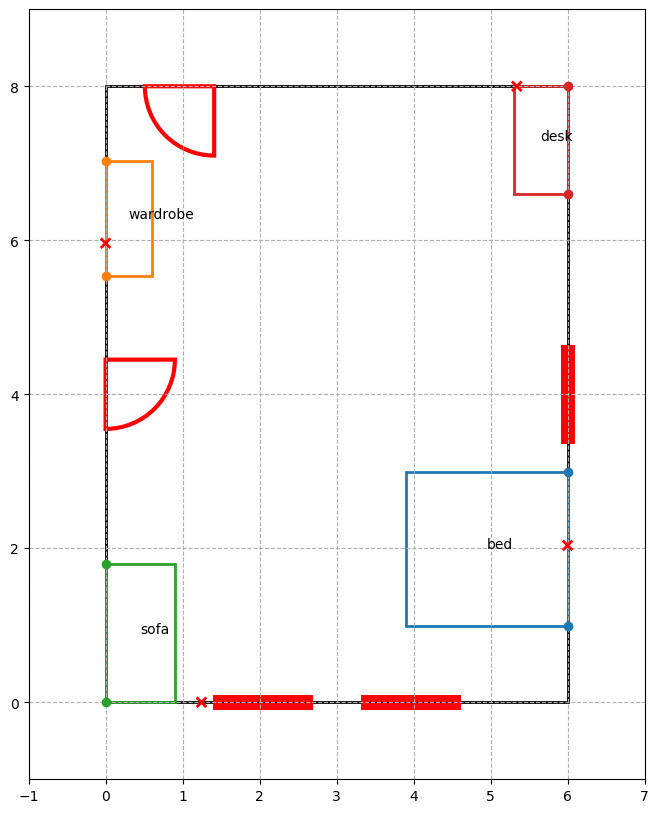

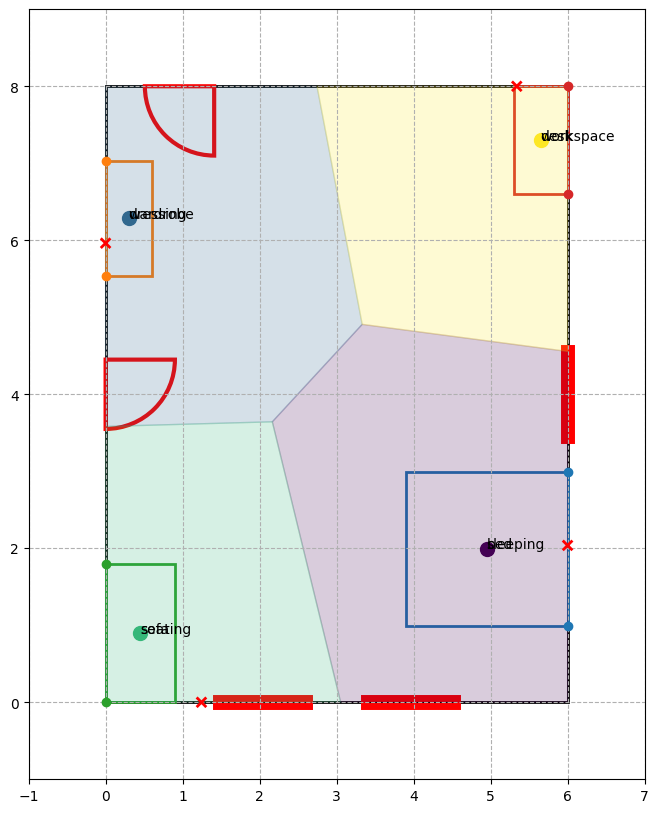

In [219]:
global_context = globals().copy()
local_context = {}  
exec(response8, global_context, local_context)
exec(code_block)

In [220]:
exec(response10)

In [221]:
global_context2 = globals().copy()
local_context2 = {}  
exec(response13, global_context2, local_context2)

In [222]:
function2 = local_context2['optimize_secondary_objects']
options = {'maxiter': 500, 'ftol': 1e-3}
room = local_context[room_name]
max_iters = 25
min_fun = np.Inf
iters = 0
while min_fun > 1e-3:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.regions)):
        positions[3*i] = room.moving_objects[i].position[0]
        positions[3*i + 1] = room.moving_objects[i].position[1]
        positions[3*i + 2] = room.moving_objects[i].position[2]
    for i in range(len(room.regions), len(room.moving_objects)): 
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi)
    res = minimize(function2, positions, args = (room), method = 'SLSQP', options = options)
    print(iters, res.fun, res.message, function2(res.x, room))
    if res.fun < min_fun:
        min_fun = res.fun
        best_res = res
    if iters == max_iters: 
        print("Max number of iterations reached.")
        break 
    iters += 1
    
for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 

room.draw() 
room.draw(draw_regions = True)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed